In [35]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import os

# Import Data

In [4]:
train_identity_df = pd.read_csv("./train_identity.csv")
train_transaction_df = pd.read_csv("./train_transaction.csv")

test_identity_df = pd.read_csv("./test_identity.csv")
test_transaction_df = pd.read_csv("./test_transaction.csv")

# Exploratory Data Analysis (EDA)

## Train Identity DF

The train_identity.csv file holds supplementary, anonymized identity and device metadata that can be joined with transaction data to improve fraud detection models. The id_01–id_38 columns are cryptic by design (to protect privacy) but serve as important engineered features for detecting abnormal or suspicious patterns.

In [5]:
train_identity_df.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [25]:
# Count total rows
train_identity_shape = train_identity_df.shape

# Count unique TransactionID values
unique_count = train_identity_df["TransactionID"].nunique()

# Print results
print(f"Total rows (shape[0])               : {train_identity_shape[0]}")
print(f"Total columns (shape[1])            : {train_identity_shape[1]}")
print(f"Number of unique TransactionID      : {unique_count}")

# Check if total rows equals number of unique TransactionID
if train_identity_shape[0] == unique_count:
    print("✅ No duplicate TransactionID found in train_identity_df.")
else:
    print("⚠️ Duplicate TransactionID detected in train_identity_df.")


Total rows (shape[0])               : 144233
Total columns (shape[1])            : 41
Number of unique TransactionID      : 144233
✅ No duplicate TransactionID found in train_identity_df.


In [30]:
# Columns contained in the train identity data frame
train_identity_df.columns

Index(['TransactionID', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06',
       'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14',
       'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22',
       'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30',
       'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo'],
      dtype='object')

## Train Transaction DF

The train_transaction.csv file serves as the core dataset with both:

- Predictive features: details of the transaction, payment method, user behavior patterns, etc.

- Target variable: isFraud indicating if the transaction was fraudulent.

When combined with train_identity.csv (via TransactionID), it gives a fuller picture of each transaction, including device and identity details.

In [20]:
train_transaction_df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
# Count total rows
train_transaction_df_shape = train_transaction_df.shape

# Count unique TransactionID values
unique_count = train_transaction_df["TransactionID"].nunique()

# Print results
print(f"Total rows (shape[0])               : {train_transaction_df_shape[0]}")
print(f"Total columns (shape[1])            : {train_transaction_df_shape[1]}")
print(f"Number of unique TransactionID      : {unique_count}")

# Check if total rows equals number of unique TransactionID
if train_transaction_df_shape[0] == unique_count:
    print("✅ No duplicate TransactionID found in train_transaction_df.")
else:
    print("⚠️ Duplicate TransactionID detected in train_transaction_df.")


Total rows (shape[0])               : 590540
Total columns (shape[1])            : 394
Number of unique TransactionID      : 590540
✅ No duplicate TransactionID found in train_transaction_df.


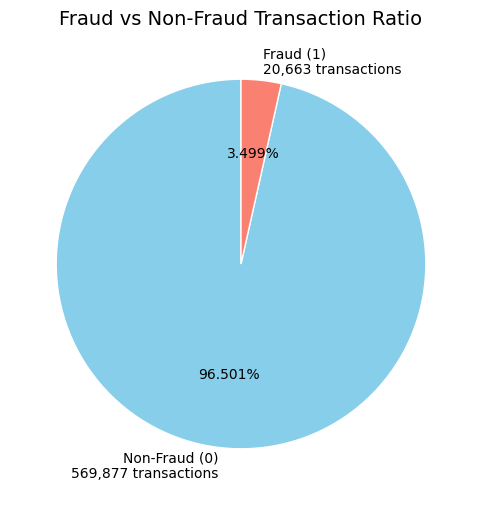

In [44]:
# Calculate the sum of each isFraud value
fraud_counts = train_transaction_df["isFraud"].value_counts()

# Create labels with specific quantities
labels = [f"Non-Fraud (0)\n{fraud_counts[0]:,} transactions",
          f"Fraud (1)\n{fraud_counts[1]:,} transactions"]

# Create pie chart
plt.figure(figsize=(6, 6))
plt.pie(
    fraud_counts,
    labels=labels,
    autopct="%1.3f%%",
    colors=["skyblue", "salmon"],
    startangle=90,
    wedgeprops={"edgecolor": "white"}
)

plt.title("Fraud vs Non-Fraud Transaction Ratio", fontsize=14)
plt.show()


## Intersection analysis between train_identitiy_df and train_transaction_df

Total TransactionID in train_identity_df        : 144233
Total TransactionID in train_transaction_df     : 590540
All identity IDs exist in transaction file?     : True
✅ All TransactionID values from train_identity_df are present in train_transaction_df.


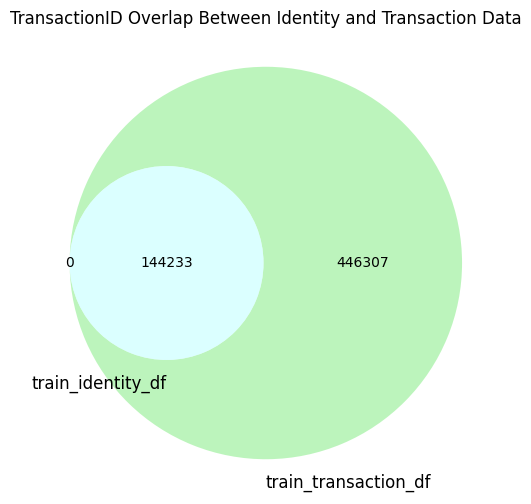

In [37]:
# Get TransactionID sets from both dataframes
ids_identity = set(train_identity_df["TransactionID"])
ids_transaction = set(train_transaction_df["TransactionID"])

# Check if all IDs in train_identity_df exist in train_transaction_df
all_exist = ids_identity.issubset(ids_transaction)

# Print the results
print(f"Total TransactionID in train_identity_df        : {len(ids_identity)}")
print(f"Total TransactionID in train_transaction_df     : {len(ids_transaction)}")
print(f"All identity IDs exist in transaction file?     : {all_exist}")

if all_exist:
    print("✅ All TransactionID values from train_identity_df are present in train_transaction_df.")
else:
    missing_ids = ids_identity - ids_transaction
    print(f"⚠️ There are {len(missing_ids)} TransactionID values in train_identity_df not found in train_transaction_df.")

# Create a Venn diagram
plt.figure(figsize=(6,6))
venn2(
    [ids_identity, ids_transaction],
    set_labels=("train_identity_df", "train_transaction_df"),
    set_colors=("skyblue", "lightgreen"),
    alpha=0.6
)
plt.title("TransactionID Overlap Between Identity and Transaction Data")
plt.show()


## Unique Person

Why Create a Unique Person ID?
1. card1–card6 contain specific card attributes

    These columns store partially masked or encoded card details, such as:
    - card1: Unique or partial card ID
    - card2: Issuer bank code
    - card3: Issuing region
    - card4: Card type (Visa, Mastercard, etc.)
    - card5: Expiration year
    - card6: Account type (debit, credit, prepaid)

    A single card typically belongs to one person or account.

2. addr1 and addr2 indicate location

    - addr1: Area/region/state code
    - addr2: Country or broader region

    These help distinguish transactions from the same card used in different locations.

3. Adding P_emaildomain and R_emaildomain for more precision

    - P_emaildomain: Purchaser’s email domain
    - R_emaildomain: Recipient’s email domain

    Including email domains further increases the uniqueness of the person identifier.

4. Why combine them?
    
    Using just one feature (e.g., card1) might overlap between different people.
    Combining card1–card6 + addr1–addr2 + P_emaildomain + R_emaildomain drastically reduces the chance of collisions, making the ID more reliable.

5. Benefits for fraud analysis

    - Track the number of transactions per person
    - Analyze purchase patterns
    - Detect repeated fraud attempts by the same individual

In [46]:
# Create a unique identifier by combining card1-card6, addr1-addr2, P_emaildomain, and R_emaildomain
train_transaction_df["unique_id"] = (
    train_transaction_df["card1"].astype(str) + "_" +
    train_transaction_df["card2"].astype(str) + "_" +
    train_transaction_df["card3"].astype(str) + "_" +
    train_transaction_df["card4"].astype(str) + "_" +
    train_transaction_df["card5"].astype(str) + "_" +
    train_transaction_df["card6"].astype(str) + "_" +
    train_transaction_df["addr1"].astype(str) + "_" +
    train_transaction_df["addr2"].astype(str) + "_" +
    train_transaction_df["P_emaildomain"].astype(str) + "_" +
    train_transaction_df["R_emaildomain"].astype(str)
)

# Count the total rows
total_rows = train_transaction_df.shape[0]

# Count the number of unique TransactionIDs
unique_transaction_ids = train_transaction_df["TransactionID"].nunique()

# Count the number of unique person IDs
unique_person_ids = train_transaction_df["unique_id"].nunique()

# Print results
print(f"Total rows                        : {total_rows}")
print(f"Unique TransactionIDs              : {unique_transaction_ids}")
print(f"Unique person IDs (card+addr+email combo): {unique_person_ids}")

# Check if each TransactionID comes from a different person
if unique_transaction_ids == unique_person_ids:
    print("✅ Each TransactionID belongs to a different unique person.")
else:
    print("⚠️ Multiple transactions may come from the same person.")


Total rows                        : 590540
Unique TransactionIDs              : 590540
Unique person IDs (card+addr+email combo): 114187
⚠️ Multiple transactions may come from the same person.
